In [25]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

### Download Historical Stock Data

In [26]:
# Download stock data for AAPL and MSFT from 2014 to 2024
aapl_data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")
msft_data = yf.download("MSFT", start="2014-01-01", end="2024-01-01")

# Focus on adjusted closing price for both stocks
aapl_close = aapl_data['Adj Close']
msft_close = msft_data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


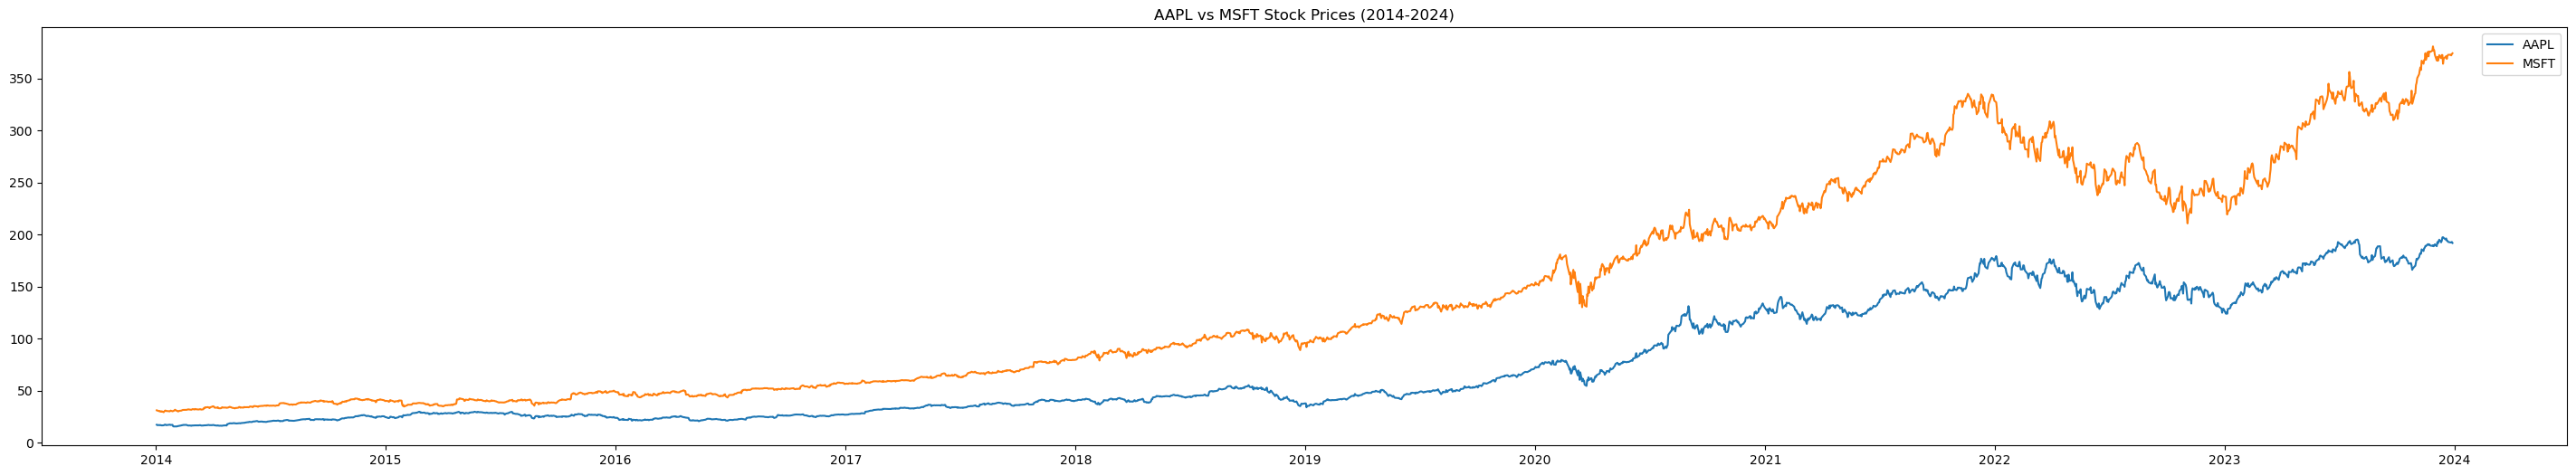

In [56]:
plt.figure(figsize=(36, 6))
plt.plot(aapl_close, label='AAPL')
plt.plot(msft_close, label='MSFT')
plt.title('AAPL vs MSFT Stock Prices (2014-2024)')
plt.legend()
plt.show()

### The Cointegration Test: Engle-Granger Two-Step Method

The most common cointegration test is the Engle-Granger test, which is a two-step process.

**Step 1: Estimate the Long-Run Relationship**

The first step is to run a simple linear regression between the two time series. For example, if we have two stock price series $P_A$ (AAPL) and $P_M$​ (MSFT), we fit the following regression model:
$$
P_A(t)=α+βP_M(t)+ϵ(t)
$$

Where:
* $P_A(t)$ is the price of stock AAPL at time $t$,
* $P_M(t)$ is the price of stock MSFT at time $t$,
* $α$ is the intercept,
* $β$ is the hedge ratio or coefficient,
* $ϵ(t)$ is the residual, or the difference between the observed and predicted prices of AAPL.

In pairs trading, this residual, $ϵ(t)$, is effectively the "spread" between the two stocks.

**Step 2: Test the Residual for Stationarity**

After estimating the hedge ratio ($β$) and obtaining the residuals $ϵ(t)$, the next step is to check whether the residuals are stationary. This is done using the Augmented Dickey-Fuller (ADF) test.
* If the residuals are stationary, it means the two series are cointegrated. Even if the stock prices themselves are non-stationary, their spread reverts to a mean over time.
* If the residuals are not stationary, the two series are not cointegrated, meaning their relationship is not stable, and they may drift apart indefinitely.

We can perform the Engle-Granger test in Python using the `coint` function from `statsmodels`.

In [57]:
score, p_value, _ = coint(aapl_close, msft_close)

The p-value is the key output of the cointegration test.
* If the p-value is below a certain threshold (commonly 0.05), we reject the null hypothesis of no cointegration, meaning the series are cointegrated.
* If the p-value is above the threshold, we accept the null hypothesis, meaning the series are not cointegrated.

Null and Alternative Hypotheses:
* Null Hypothesis ($H_0$): There is no cointegration between the time series (the spread is not stationary)
* Alternative Hypothesis ($H_1$): There is cointegration between the time series (the spread is stationary)

In [58]:
print(f"Cointegration Test p-value: {p_value}")

Cointegration Test p-value: 0.1335355783469518


The p-value is 0.13354 (5 d.p.), indicating weak cointegration between AAPL and MSFT; however, we will still proceed with the strategy for the sake of exploring its logic.

### Calculate the Spread

The spread is the difference between the two stocks' price, potentially adjusted with a hedge ratio. We calculate the hedge ratio by regressing one stock's price against the other.

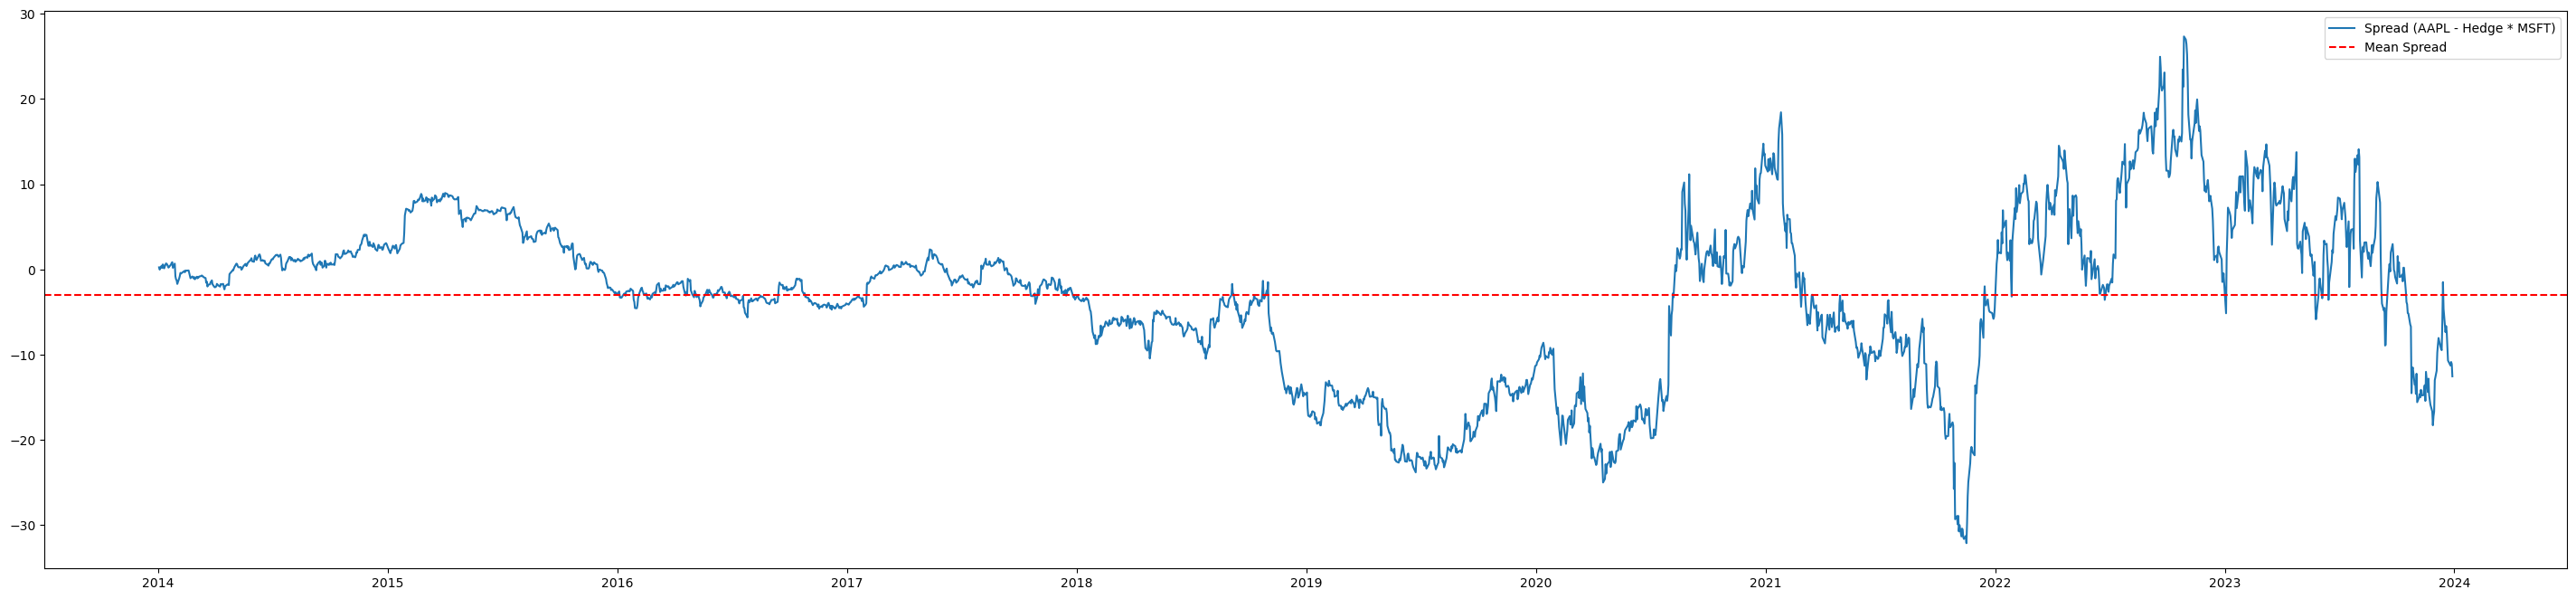

In [66]:
# Perform linear regression (AAPL ~ MSFT)
X = sm.add_constant(msft_close)
model = sm.OLS(aapl_close, X).fit()

# Extract hedge ratio
hedge_ratio = model.params.iloc[1]
intercept = model.params.iloc[0]

# Calculate spread
spread = aapl_close - hedge_ratio * msft_close

# Plot spread
plt.figure(figsize=(36, 8))
plt.plot(spread, label='Spread (AAPL - Hedge * MSFT)')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()

### Generate Trading Signals Using Bollinger Bands

A simple pairs trading strategy is to go long the spread when it is below a certain threshold (_i.e._, the spread is too negative) and go short when it is above a threshold.

Bollinger Bands provide a useful way to define potential entry and exit points in a pairs trading strategy by identifying whether the spread between two cointegrated stocks is moving beyond its typical range. They consist of:

* Middle Band: Usually a simple moving average (SMA) of the spread.
* Upper Band: The SMA plus two standard deviations of the spread.
* Lower Band: The SMA minus two standard deviations of the spread.

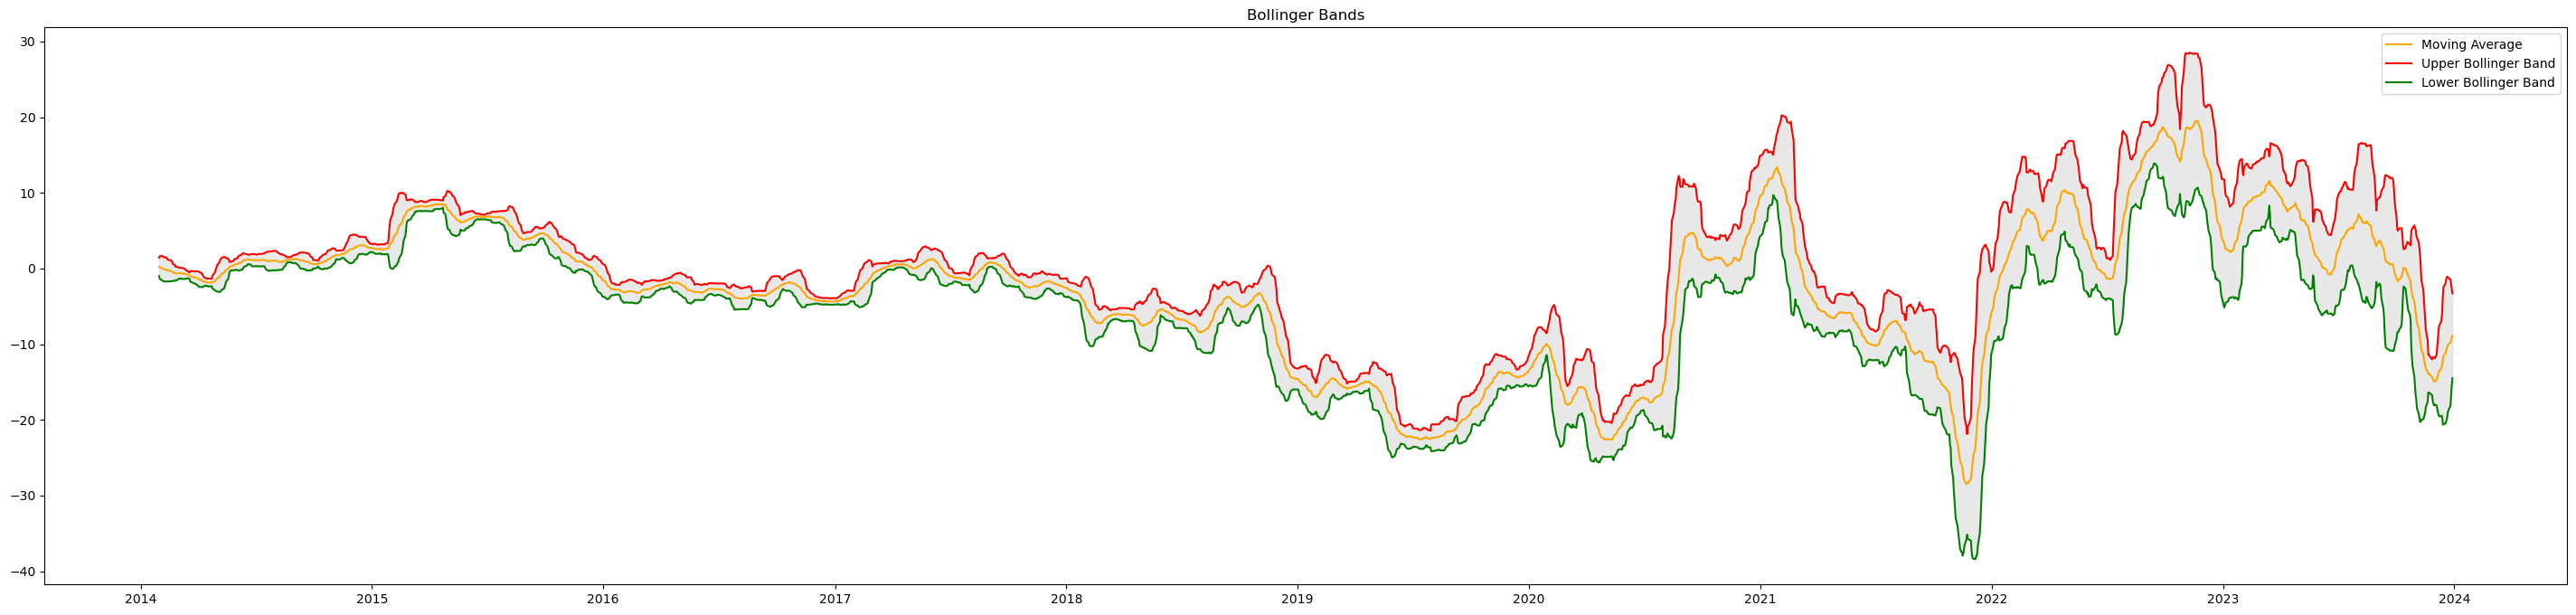

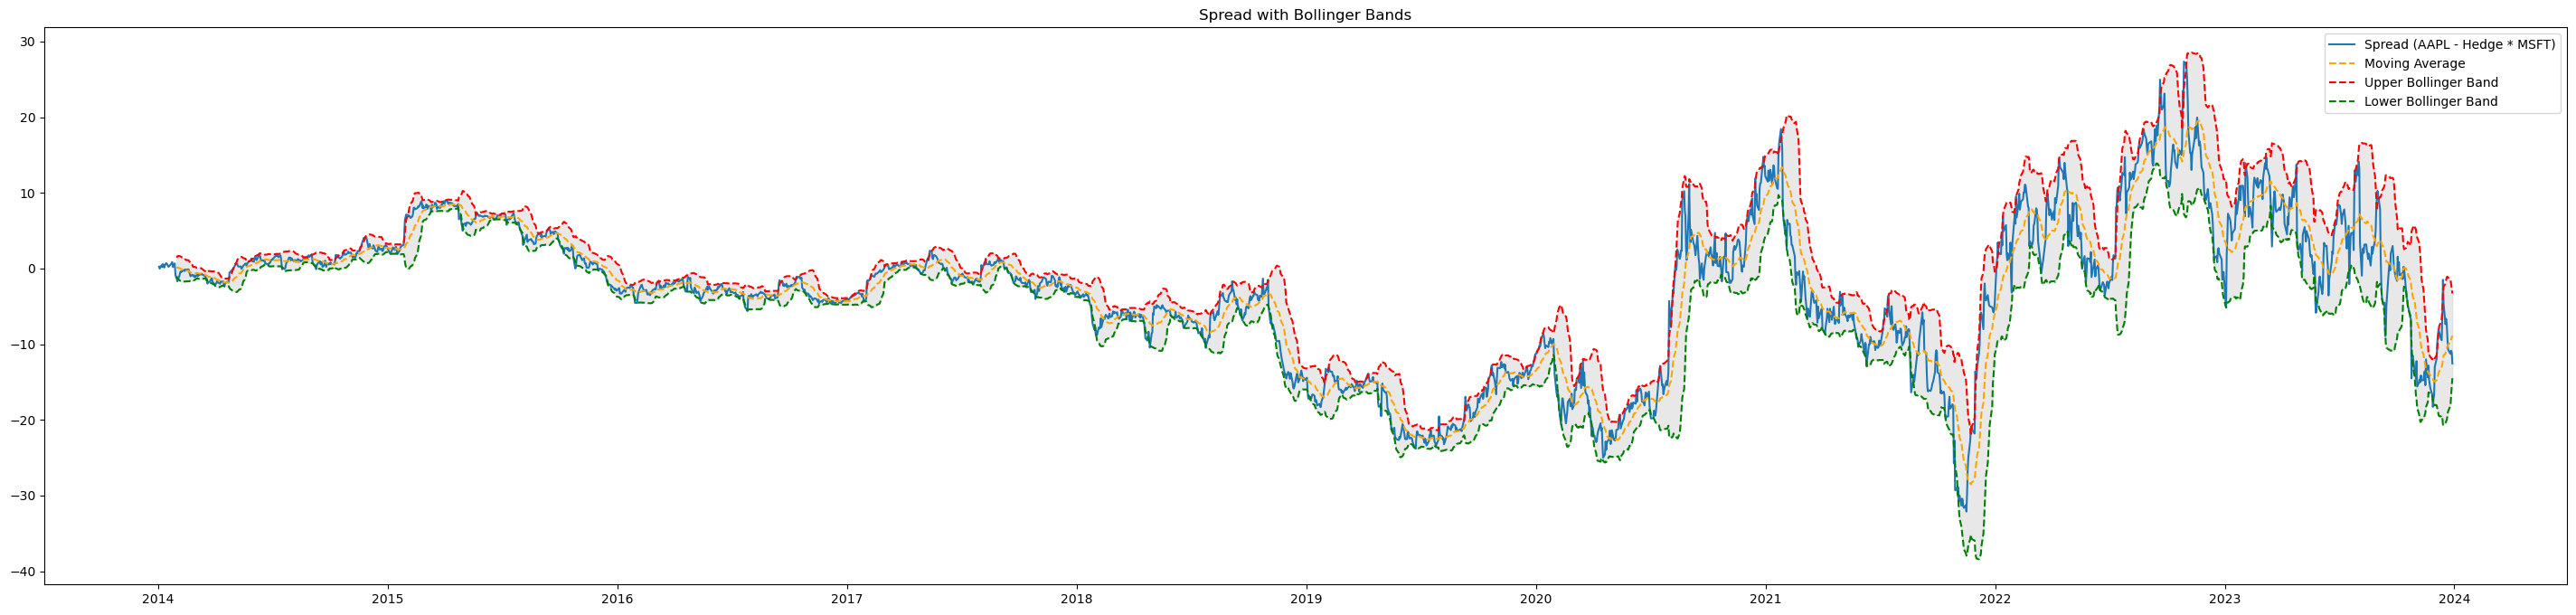

In [60]:
# Calculate Bollinger Bands
window = 20 

# Calculate moving average and standard deviation
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

# Calculate upper and lower Bollinger Bands
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)


# Plot Bollinger Bands
plt.figure(figsize=(36, 8))

plt.plot(rolling_mean, label='Moving Average', color='orange')
plt.plot(upper_band, label='Upper Bollinger Band', color='red')
plt.plot(lower_band, label='Lower Bollinger Band', color='green')

plt.fill_between(spread.index, upper_band, lower_band, color='lightgray', alpha=0.5)

plt.title('Bollinger Bands')
plt.legend()


# Plot Bollinger Bands with Spread
plt.figure(figsize=(36, 8))

plt.plot(spread, label='Spread (AAPL - Hedge * MSFT)')
plt.plot(rolling_mean, label='Moving Average', color='orange', linestyle='--')
plt.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

plt.fill_between(spread.index, upper_band, lower_band, color='lightgray', alpha=0.5)

plt.title('Spread with Bollinger Bands')
plt.legend()
plt.show()

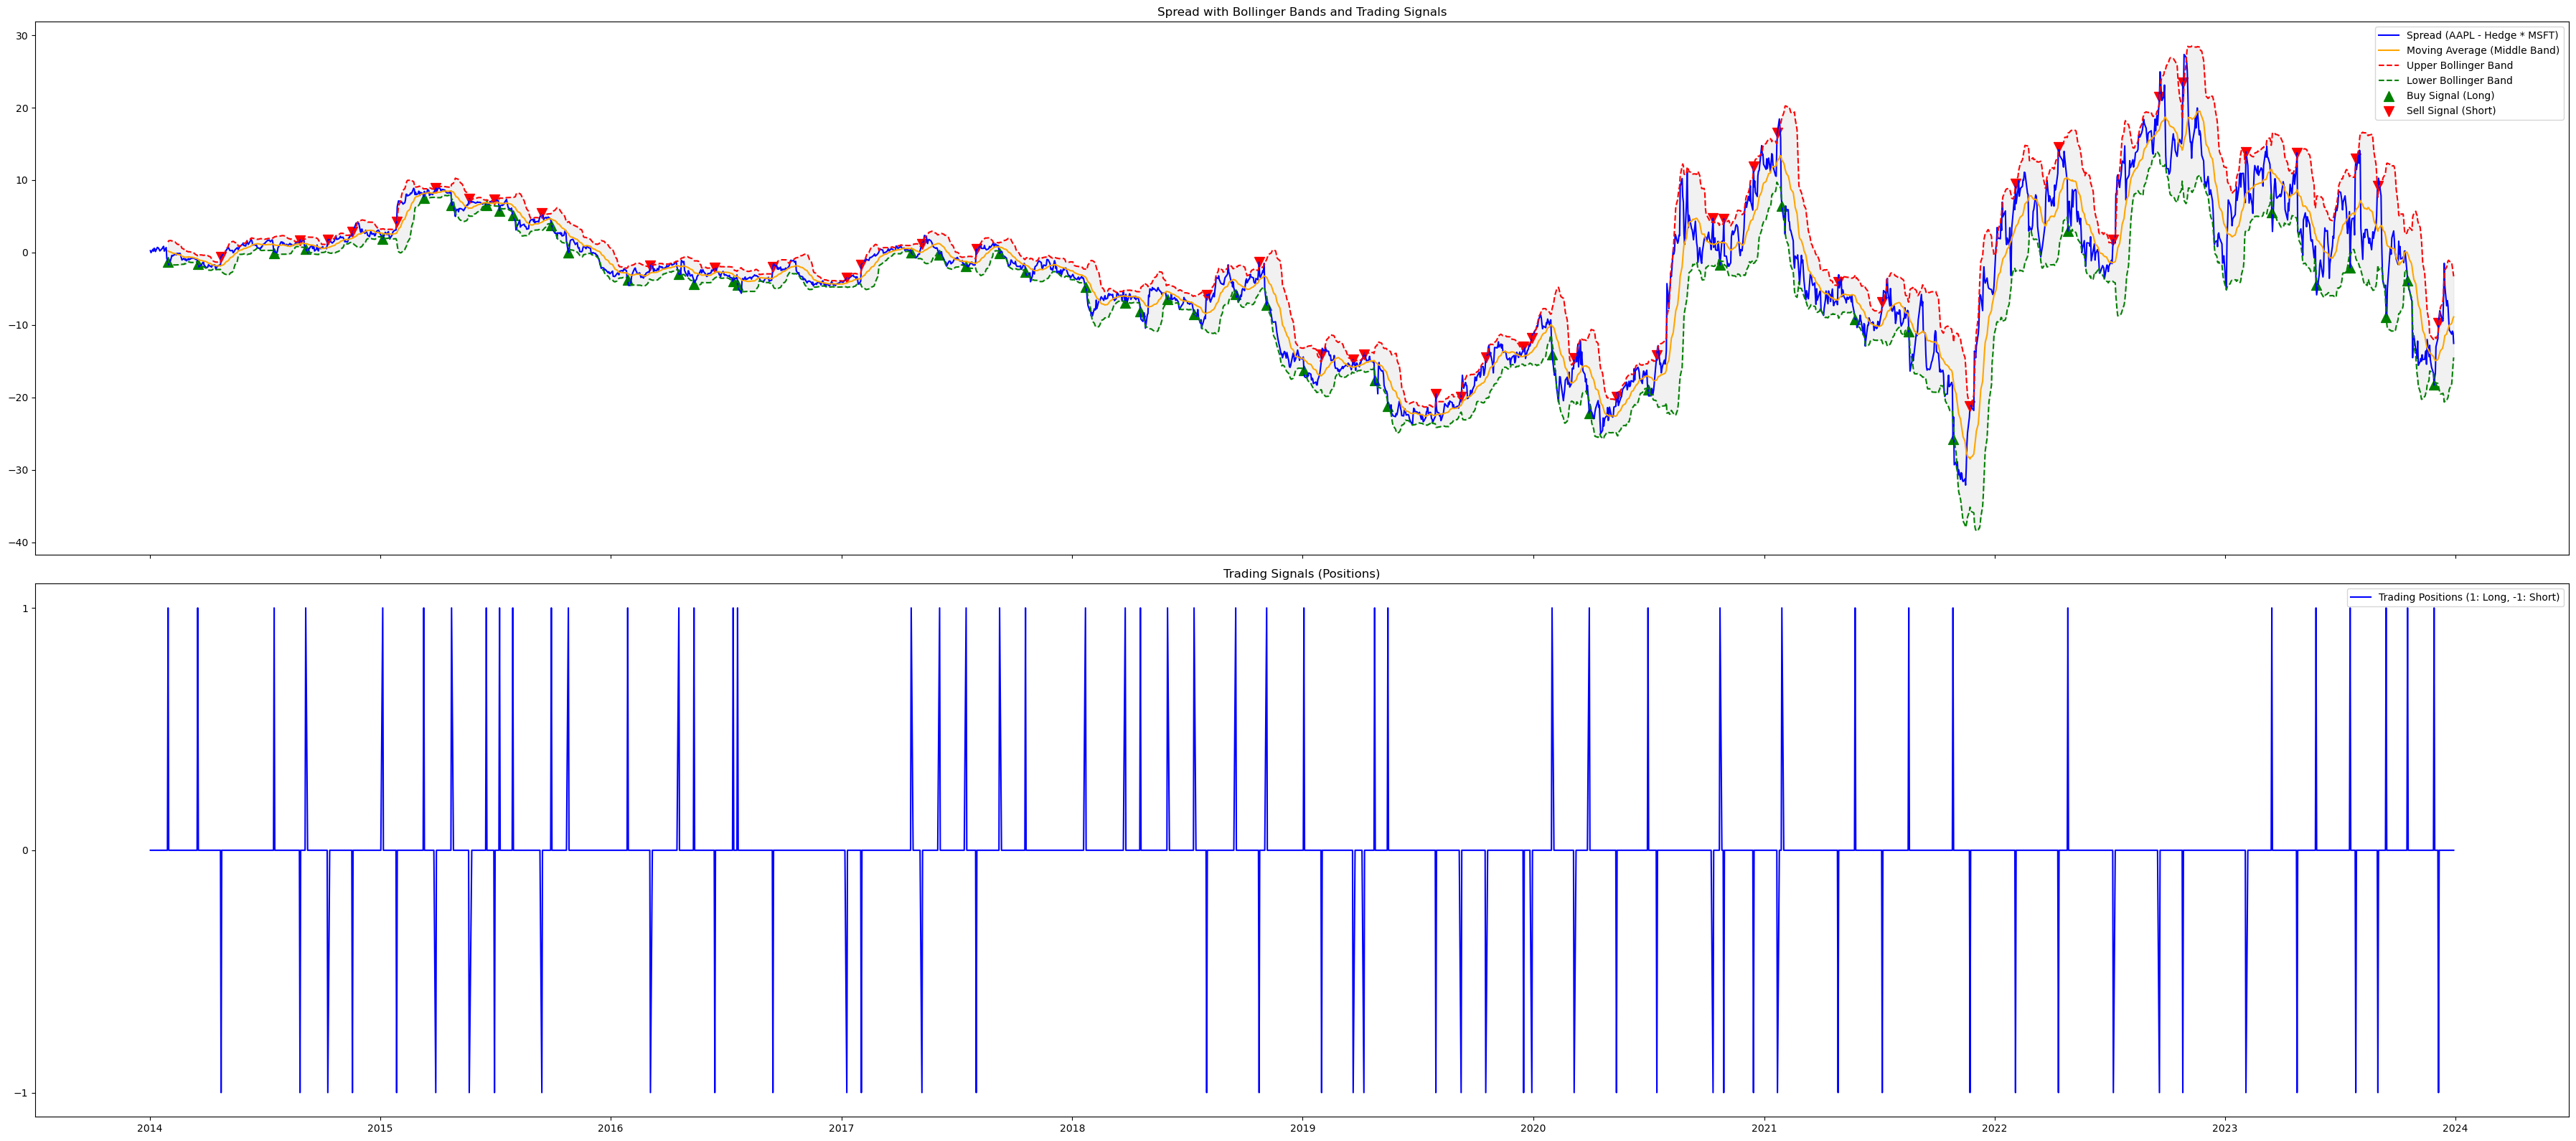

In [63]:
# Initialise signals DataFrame
signals = pd.DataFrame(index=spread.index)
signals['spread'] = spread
signals['positions'] = 0

# Variable to track state
current_position = 0  # 0 = no active position; 1 = long; -1 = short


# Loop through the spread to generate trading signals
for i in range(1, len(spread)):
    # If no position is currently held
    if current_position == 0:
        # Generate long signal if spread falls below the lower band
        if spread.iloc[i] < lower_band.iloc[i]:
            signals.loc[signals.index[i], 'positions'] = 1  # Long position
            current_position = 1  # Set current position to long
            
        # Generate short signal if spread rises above the upper band
        elif spread.iloc[i] > upper_band.iloc[i]:
            signals.loc[signals.index[i], 'positions'] = -1  # Short position
            current_position = -1  # Set current position to short
    
    # If a long or short position is held, exit when the spread returns to the mean
    elif current_position == 1 and spread.iloc[i] >= rolling_mean.iloc[i]:
        signals.loc[signals.index[i], 'positions'] = 0  # Exit long position
        current_position = 0  # Reset current position to no position
        
    elif current_position == -1 and spread.iloc[i] <= rolling_mean.iloc[i]:
        signals.loc[signals.index[i], 'positions'] = 0  # Exit short position
        current_position = 0  # Reset current position to no position

# Fill forward 'positions' to reflect position until it changes
signals['positions'] = signals['positions'].ffill().fillna(0)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(36, 16), sharex=True)

# Plot the spread with Bollinger Bands on the first axis (ax1)
ax1.plot(spread, label='Spread (AAPL - Hedge * MSFT)', color='blue')
ax1.plot(rolling_mean, label='Moving Average (Middle Band)', color='orange')
ax1.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
ax1.plot(lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

ax1.fill_between(spread.index, lower_band, upper_band, color='lightgray', alpha=0.3)

ax1.scatter(spread[signals['positions'] == 1].index, spread[signals['positions'] == 1], 
            marker='^', color='green', label='Buy Signal (Long)', s=100)
ax1.scatter(spread[signals['positions'] == -1].index, spread[signals['positions'] == -1], 
            marker='v', color='red', label='Sell Signal (Short)', s=100)

ax1.set_title('Spread with Bollinger Bands and Trading Signals')
ax1.legend()


# Plot the trading positions on the second axis (ax2)
ax2.plot(signals['positions'], label='Trading Positions (1: Long, -1: Short)', color='blue')

ax2.set_yticks([1, 0, -1])
ax2.set_title('Trading Signals (Positions)')
ax2.legend()

plt.tight_layout()


### Backtest the Strategy

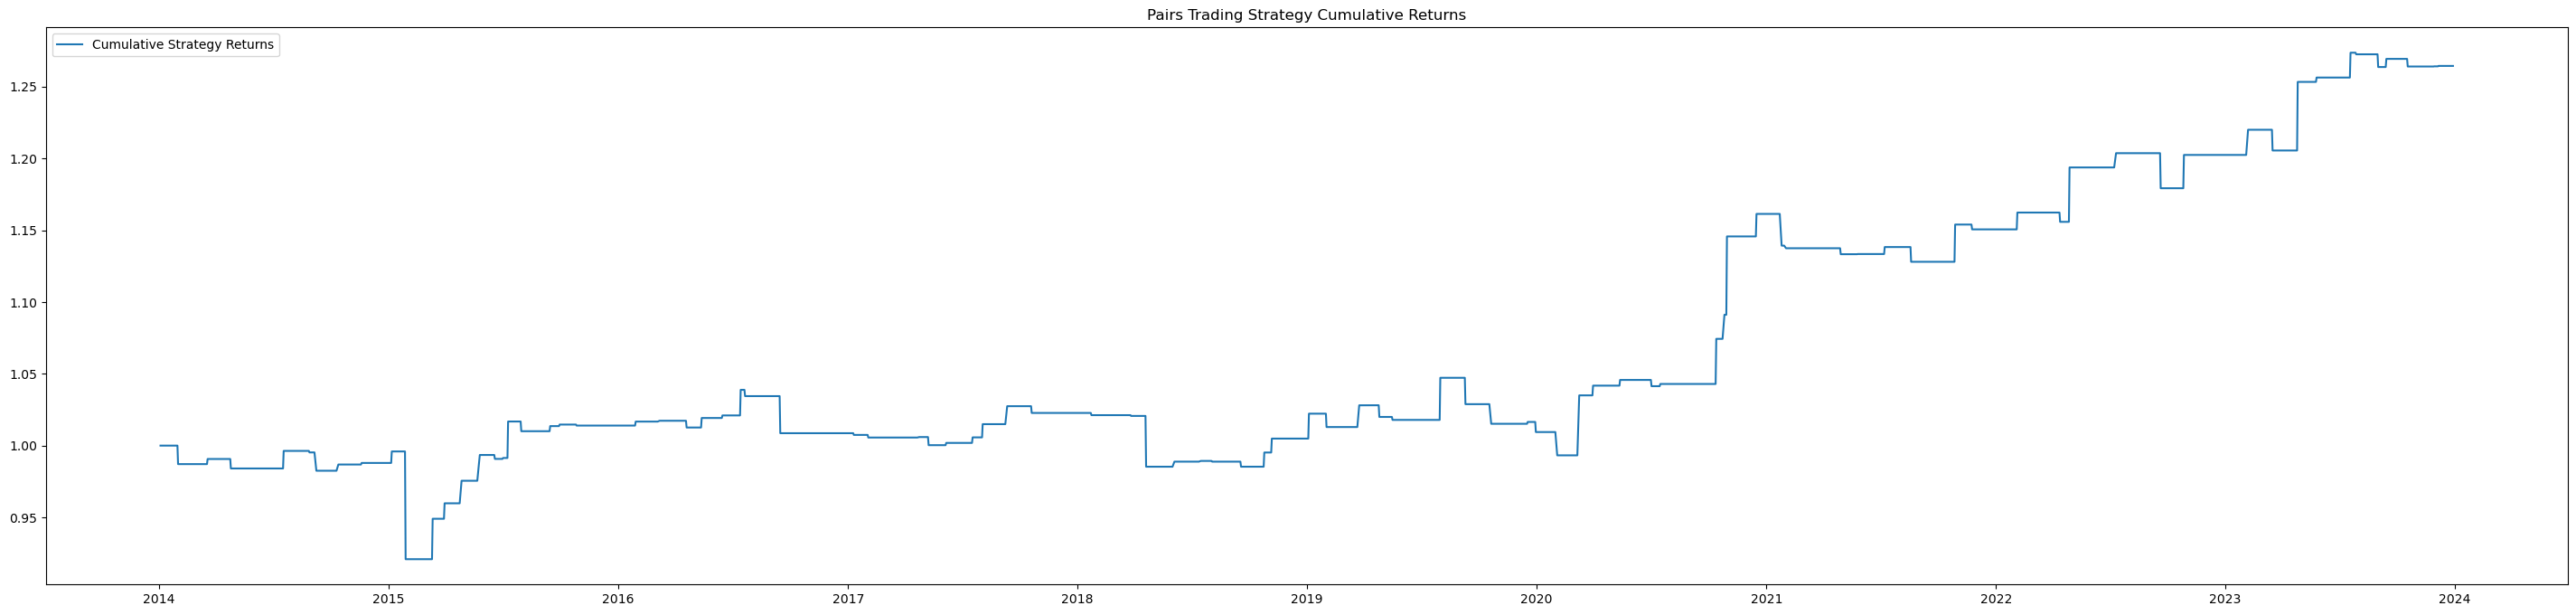

In [64]:
# Calculate returns for AAPL and MSFT
aapl_returns = aapl_close.pct_change().dropna()
msft_returns = msft_close.pct_change().dropna()

# Calculate the strategy returns based on the hedge ratio
strategy_returns = signals['positions'].shift(1) * (aapl_returns - hedge_ratio * msft_returns)

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(36, 8))
plt.plot(cumulative_returns, label='Cumulative Strategy Returns')
plt.title('Pairs Trading Strategy Cumulative Returns')
plt.legend()